In this notebook I will try to fit a single star PSF model to a calibrator star from kernel phase data set. 
To do that I will need to fit only x, y center positions and median flux as in de Furio paper. In addition to that we I can add phase retrieval and improve model-data fitting

To fit a binary model, which I will do in a separate notebook, I will need to have more parameters, but first basic parameters are  x and y center of the primary, flux normalization of the primary, separation between the centers of the primary and secondary, the position angle of the center of the secondary relative to the primary, and the flux ratio between the secondary and primary. On top of that I can add phase retrieval parameters to the model. 

Functions I need:
1. grid search in x,y parameter space
2. plots to save
3. data for plots to be saved
4. de furio like 3x3 plot with fitting single and binary models to the binary data
5. sbatch run file
6. repeate code for every filter

In [1]:
import jax
from jax.config import config
config.update("jax_enable_x64", True)

import dLux as dl
from matplotlib import colors, pyplot as plt
import jax.numpy as np
from jax import jit, vmap
import jax.random as jr

import webbpsf
from astropy.io import fits
import astropy.units as u
from tqdm.notebook import tqdm

from dLuxWebbpsf import NIRCamCoron

Step 1: Make fake data with the same parameters as real data.

Filename: KF_test.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  OVERSAMP      1 PrimaryHDU     123   (316, 316)   float64   
  1  DET_SAMP      1 ImageHDU       124   (79, 79)   float64   
  2  OVERDIST      1 ImageHDU       168   (316, 316)   float64   
  3  DET_DIST      1 ImageHDU       169   (79, 79)   float64   


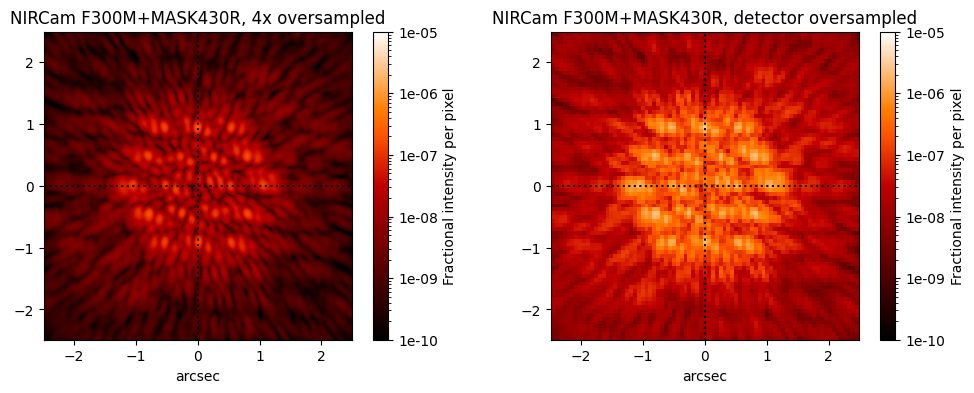

In [2]:
def get_osys(instrument, filtr, pup_mask, crn_mask, detector, aperture):
    webb_osys = getattr(webbpsf, instrument)()
    webb_osys.filter = filtr
    webb_osys.pupil_mask = pup_mask
    webb_osys.image_mask = crn_mask
    webb_osys.detector = detector
    webb_osys.set_position_from_aperture_name(aperture)
    
    return webb_osys

webb_options = {
    'jitter': None,   # jitter model name or None
    'jitter_sigma': 0.000,  # in arcsec per axis, default 0.007
    'add_distortion': False,
}

def get_nircam(source_offset_x = 0, source_offset_y = 0):
    webb_osys = get_osys("NIRCam", "F300M", "CIRCLYOT", "MASK430R", "NRCA5", "NRCA5_FULL_MASK430R") #same as nc.
    webb_osys.options.update(webb_options)
    return webb_osys


#webb_osys = get_nircam(source_offset_x, source_offset_y)
webb_osys = get_nircam()

def recalc_psf(osys, filename):
    osys.calc_psf(filename, oversample=4) #, monochromatic=3.0e-6)   # create highly oversampled output image

    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    webbpsf.display_psf(filename, vmin=1e-10, vmax=1e-5,
        ext='OVERSAMP', title='NIRCam F300M+MASK430R, 4x oversampled', crosshairs=True)
    plt.subplot(1,2,2)
    webbpsf.display_psf(filename, vmin=1e-10, vmax=1e-5,
        ext='DET_SAMP', title='NIRCam F300M+MASK430R, detector oversampled', crosshairs=True)
    
recalc_psf(webb_osys, 'KF_test.fits')


hdul = fits.open('KF_test.fits')
hdul.info()

webbpsf_header = hdul[0].header
webbpsf_data = hdul[0].data
webbpsf_norm = webbpsf_data/webbpsf_data.sum()

hdul.close()

head = webbpsf_header
nwavels = head['NWAVES']
wavels, weights = [], []
for i in range(nwavels):
    wavels.append(head['WAVE'+str(i)])
    weights.append(head['WGHT'+str(i)])

In [21]:
webb_options = {
    'jitter': None,   # jitter model name or None
    'jitter_sigma': 0.000,  # in arcsec per axis, default 0.007
    'add_distortion': False,
}

optics = NIRCamCoron(filter = "F300M",
                     pupil_mask = "CIRCLYOT",
                     coron_mask = "MASK430R",
                     detector = "NRCA5",
                     aperture = "NRCA5_FULL_MASK430R",
                     fft_oversample=4,
                     options=webb_options)

spec = dl.Spectrum(wavels, weights)


source_offset_x = 0.1 *  np.pi/(180*3600)
source_offset_y = 0.25 *  np.pi/(180*3600)
offset = np.array([source_offset_x, source_offset_y])

#offset = np.array([-source_offset_y, source_offset_x / 47 * np.pi]) #test with different offset later
#offset = np.array([0,0])

# wavelengths are still required even if they are discarded
source = dl.PointSource(wavelengths=wavels, spectrum=spec, position=offset)


telescope = dl.Instrument(optics, (source,'source'))

opd_ref_focus: {} 6.714345736893632e-08
tilt_ref_offset: {} 5.412406381286715e-08


Step 2: Make an optical model for optimisation where source will be parametrised.

the solution that they have for this same problem in https://github.com/amerand/CANDID, a popular interferometry data analysis code, is to calculate the likelihood on a grid of xy with other parameters held constant, to identify the best position to start
see that page - scroll down to ‘CHI2MAP’ and ‘FITMAP’

In [26]:
@jit
def model_optics_jit():
    return telescope.model()

In [27]:
%%time
print("Modelling optics...")
psf = model_optics_jit()
print("Modelling optics...ok")

Modelling optics...
Modelling optics...ok
CPU times: user 22.2 s, sys: 674 ms, total: 22.9 s
Wall time: 8.82 s


In [28]:
psf_photon = 1*jr.poisson(jr.PRNGKey(0), psf)
bg_noise = 0.01*jr.normal(jr.PRNGKey(0), psf_photon.shape)
data = psf_photon + bg_noise

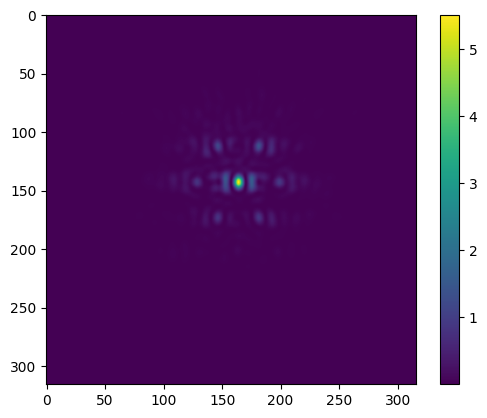

In [29]:
plt.imshow(psf)
plt.colorbar()

In [35]:
parameters = ['source.position']

# Define the likelihood function
model = telescope

# Define the meshgrid
xsize = 3
ysize = 3
allsize = xsize*ysize

xx, yy = np.meshgrid(np.linspace(-1, 1, xsize), np.linspace(-1, 1, ysize))

xr = xx.reshape((allsize))
yr = yy.reshape((allsize))


In [36]:
#@jit
#def likelihood(x, y, expected_data):
    model_data = model.set(parameters, [[x, y]]).model()
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared  #log likelihood
    return likelihood

In [37]:
%%time
likelihoods_list = []
for x, y, token in zip(xr, yr, tqdm(range(allsize))):
    LH = likelihood(x, y, data)
    likelihoods_list.append(LH)
    residuals = data - model.set(parameters, [[x, y]]).model()
    chi_squared = np.sum(residuals**2)
    print(f"x={x}, y={y}, chi_squared={chi_squared}, likelihood={LH}")

likelihoods = np.array(likelihoods_list).reshape((xsize, ysize))

  0%|          | 0/9 [00:00<?, ?it/s]

x=-1.0, y=-1.0, chi_squared=91163.10910314048, likelihood=-45581.554551570276
x=0.0, y=-1.0, chi_squared=93387.02003379863, likelihood=-46693.51001689934
x=1.0, y=-1.0, chi_squared=91219.36220086705, likelihood=-45609.681100433576
x=-1.0, y=0.0, chi_squared=93376.47420827753, likelihood=-46688.237104138694
x=0.0, y=0.0, chi_squared=3547.6691485379292, likelihood=-1773.8345742689646
x=1.0, y=0.0, chi_squared=92784.32409991891, likelihood=-46392.16204995934
x=-1.0, y=1.0, chi_squared=91157.60641948998, likelihood=-45578.803209744976
x=0.0, y=1.0, chi_squared=93122.44996803199, likelihood=-46561.224984016044
x=1.0, y=1.0, chi_squared=91163.5375161402, likelihood=-45581.76875807011
CPU times: user 6min 55s, sys: 4min 21s, total: 11min 16s
Wall time: 5min 53s


In [31]:
from jax import lax

def likelihood(x, y, expected_data):
    model_data = model.set(parameters, [[x, y]]).model()
    residuals = expected_data - model_data
    # calculate the chi-squared value
    chi_squared = np.sum(residuals**2)
    # calculate the likelihood
    likelihood =  -0.5 * chi_squared  #log likelihood
    print(f"x={x}, y={y}, chi_squared={chi_squared}")
    return likelihood

@jit
def likelihood_fast(x,y,expected_data):
    likelihood_c = lambda args : likelihood(args[0], args[1], expected_data)
    args = np.stack((x, y), axis=-1)
    return lax.map(likelihood_c, args)


In [32]:
%%time
out = likelihood_fast(xr, yr, data)

x=Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, y=Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>, chi_squared=Traced<ShapedArray(float64[])>with<DynamicJaxprTrace(level=2/0)>
CPU times: user 2min 19s, sys: 1min 19s, total: 3min 39s
Wall time: 2min 47s


In [33]:
likelihoods = np.array(out).reshape((xsize, ysize))
print(likelihoods)

ind_argmax = out.argmax()
coords=(xr[ind_argmax], yr[ind_argmax])

#ind_max = np.unravel_index(likelihoods.argmax(), likelihoods.shape)
#coords=(xx[ind_max[0], ind_max[1]], yy[ind_max[0], ind_max[1]])

print(coords)

[[-45581.55455158 -46693.51001693 -45609.68110043]
 [-46688.23710415  -1773.83457427 -46392.16204996]
 [-45578.80320974 -46561.22498402 -45581.76875805]]
(Array(0., dtype=float64), Array(0., dtype=float64))


Step 3: Set up HMC parameters and distributions.

Step 4: Run HMC and make pretty plots.